# modsim.py examples

Code for *Modeling and Simulation in Python*

by Allen B. Downey, available from http://greenteapress.com

Copyright 2017 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
from scipy.integrate import odeint

from pint import UnitRegistry
UNITS = UnitRegistry()

In [2]:
# TODO: move these definitions into simplot.py

In [3]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    If d is None, create a new dictionary.

    d: dictionary
    options: keyword args to add to d
    """
    if d is None:
        d = {}

    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [4]:
class Simplot:
    
    def __init__(self):
        self.figure_states = dict()
        
    def get_figure_state(self, figure=None):
        if figure is None:
            figure = plt.gca()
        
        try:
            return self.figure_states[figure]
        except KeyError:
            figure_state = FigureState()
            self.figure_states[figure] = figure_state
            return figure_state
    
SIMPLOT = Simplot()

In [5]:
class FigureState:
    
    def __init__(self):
        self.lines = dict()
        
    def get_line(self, style, kwargs):
        key = style, kwargs.get('color')
        
        try:
            return self.lines[key]
        except KeyError:
            line = self.make_line(style, kwargs)
            self.lines[key] = line
            return line
    
    def make_line(self, style, kwargs):
        underride(kwargs, linewidth=2, alpha=0.6)
        lines = plt.plot([], style, **kwargs)
        return lines[0]

In [6]:
def plot(*args, **kwargs):
    """Makes line plots.
    
    args can be:
      plot(y)
      plot(y, style_string)
      plot(x, y)
      plot(x, y, style_string)
    
    kwargs are the same as for pyplot.plot
    
    If x or y have attributes label and/or units,
    label the axes accordingly.
    
    """
    x = None
    y = None
    style = 'bo-'
    
    # parse the args the same way plt.plot does:
    # 
    if len(args) == 1:
        y = args[0]
    elif len(args) == 2:
        if isinstance(args[1], str):
            y, style = args
        else:
            x, y = args
    elif len(args) == 3:
        x, y, style = args
    
    # label the y axis
    label = getattr(y, 'label', 'y')
    units = getattr(y, 'units', 'dimensionless')
    plt.ylabel('%s (%s)' % (label, units))
    
    # label the x axis
    label = getattr(x, 'label', 'x')
    units = getattr(x, 'units', 'dimensionless')
    plt.xlabel('%s (%s)' % (label, units))
        
    #print(type(x))
    #print(type(y))
        
    figure = plt.gcf()
    figure_state = SIMPLOT.get_figure_state(figure)
    line = figure_state.get_line(style, kwargs)
    
    ys = line.get_ydata()
    ys = np.append(ys, y)
    line.set_ydata(ys)
    
    if x is None:
        xs = np.arange(len(ys))
    else:
        xs = line.get_xdata()
        xs = np.append(xs, x)
    
    line.set_xdata(xs)
    
    #print(line.get_xdata())
    #print(line.get_ydata())
    
    axes = plt.gca()
    axes.relim()
    axes.autoscale_view()
    figure.canvas.draw()
    
def newplot():
    plt.figure()
    
def labels(ylabel, xlabel, title=None, **kwargs):
    plt.ylabel(ylabel, **kwargs)
    plt.xlabel(xlabel, **kwargs)
    plt.title(title, **kwargs)

In [7]:
def slope_func(Y, t):
    y1, y2 = Y
    y1p = y2
    y2p = -(y2 + y1)
    return y1p, y2p

In [8]:
y_init = [1, 0]
y_init

[1, 0]

In [9]:
slope_func(y_init, 0)

(0, -1)

In [10]:
ts = np.arange(0, 15.0, 0.1)
type(ts)

numpy.ndarray

In [11]:
def ode_solve_nondim(slope_func, y_init, ts):
    """
    """    
    y_mags = [(y.magnitude if isinstance(y, UNITS.Quantity) else y)
               for y in y_init]
    #print(y_mags)
        
    y_units = [(y.units if isinstance(y, UNITS.Quantity) else UNITS.dimensionless)
               for y in y_init]
    #print(y_units)
        
    # invoke the ODE solver
    asol = odeint(slope_func, y_mags, ts)
    
    cols = asol.transpose()
    res = [col * unit for col, unit in zip(cols, y_units)]
    
    return res

In [12]:
def ode_solve(slope_func, y_init, ts):
    """
    """
    # TODO: check that slope_func returns elements that have the right units
    y_init = np.asarray(y_init, dtype=object)
        
    # invoke the ODE solver
    asol = odeint(slope_func, y_init, ts)
    
    cols = asol.transpose()
    res = [col * unit for col, unit in zip(cols, y_units)]
    
    return res

In [13]:
y_init

[1, 0]

In [14]:
position, velocity = ode_solve_nondim(slope_func, y_init, ts)

In [15]:
position.label = 'position'
position.units

<Unit('dimensionless')>

In [16]:
velocity.label = 'velocity'
velocity.units

<Unit('dimensionless')>

<IPython.core.display.Javascript object>


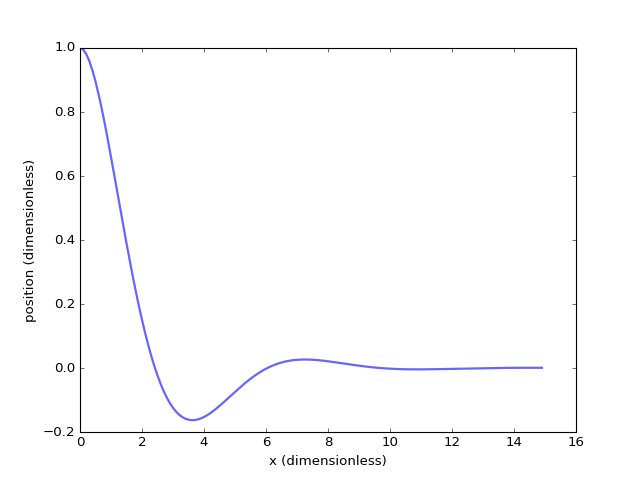

In [17]:
newplot()
plot(ts, position, 'b')

In [18]:
cm = UNITS.centimeter
g = UNITS.gram
kg = UNITS.kilogram
s = UNITS.second
N = UNITS.newton
m = UNITS.meter

In [19]:
mass = 0.1 * (kg)
k = 1 * (N / m)
c = 0 * (N / (m/s))

In [20]:
def slope_func(Y, t):
    y1, y2 = Y
    y1p = y2
    y2p = -(c*y2 + k*y1) / mass
    return y1p, y2p

In [21]:
def slope_func_nondim(Y, t):
    c = c.magnitude
    k = k.magnitude
    mass = mass.magnitude
    
    y1, y2 = Y
    y1p = y2
    y2p = -(c*y2 + k*y1) / mass
    return y1p, y2p

In [22]:
y_init = [0.01 * (m), 0 * (m/s)]
y_init

[<Quantity(0.01, 'meter')>, <Quantity(0, 'meter / second')>]

In [23]:
slope_func(y_init, 0)

(<Quantity(0, 'meter / second')>, <Quantity(-0.1, 'newton / kilogram')>)

In [24]:
ts = np.arange(0, 15.0, 0.1) * (s)
ts.label = 'time'
ts

<Quantity([  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9], 'second')>

In [65]:
def euler(slope_func, y_init, ts):
    print(slope_func.func_closure)
    for name in slope_func.func_closure:
        print(name)
    return
    
    
    asol = np.empty((len(ts), len(y_init)))
    hs = np.diff(ts) * ts.units

    units = [yi.units for yi in y_init]
    asol[0] = [yi.magnitude for yi in y_init]
    
    y = np.asarray(y_init, dtype=object)
    
    for i, h in enumerate(hs):
        slope = slope_func(y, ts[i])
        y = [yi + h * si for yi, si in zip(y, slope)]
        asol[i+1] = [yi.magnitude for yi in y]
    
    cols = asol.transpose()
    res = [col * unit for col, unit in zip(cols, units)]
    return res

In [66]:
position, velocity = euler(slope_func, y_init, ts)

None


TypeError: 'NoneType' object is not iterable

<IPython.core.display.Javascript object>


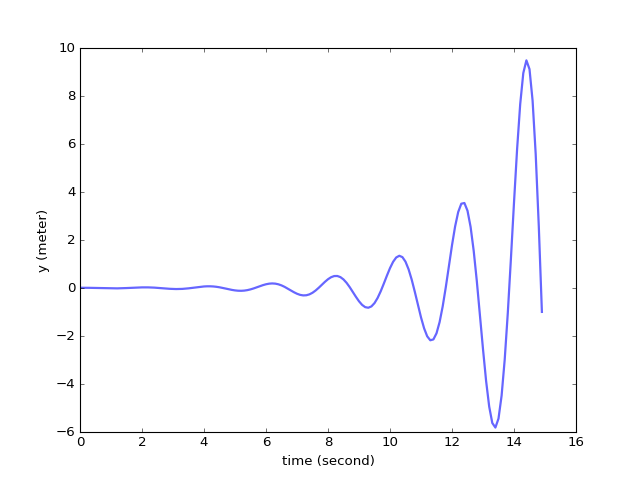

In [27]:
newplot()
plot(ts, position, 'b')

<IPython.core.display.Javascript object>


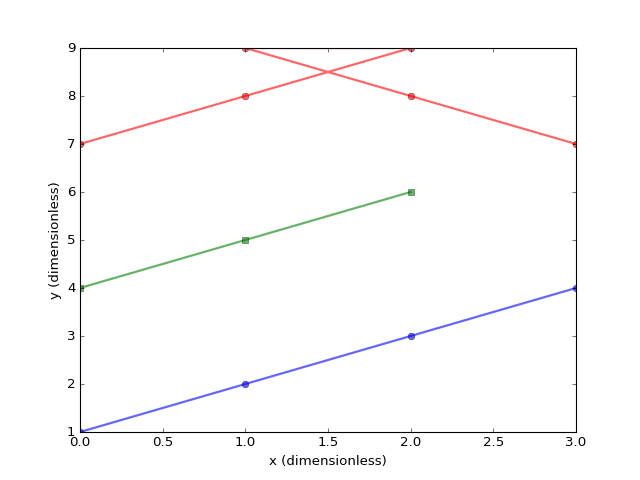

In [28]:
newplot()

In [29]:
plot(1)

In [30]:
plot([2,3,4])

In [31]:
plot([4,5,6], 'gs-')

In [32]:
plot([7,8,9], color='red')

In [33]:
plot([1,2,3], [9,8,7], color='red')

<IPython.core.display.Javascript object>


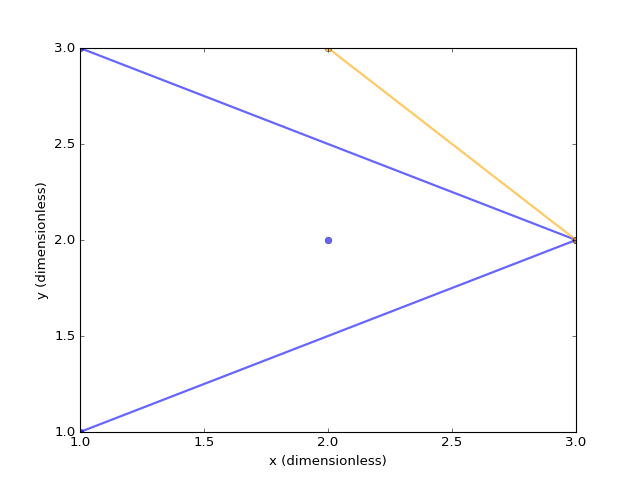

In [34]:
newplot()

In [35]:
plot(1, 1, 'bo-')

In [36]:
plot(2, 2, 'bo')

In [37]:
plot(3, 2, 'bo-')

In [38]:
plot(3, 2, color='orange')

In [39]:
plot(2, 3, color='orange')

In [40]:
plot(1, 3)

In [41]:
labels('The y axis', 'The x axis', 'The title')

<IPython.core.display.Javascript object>


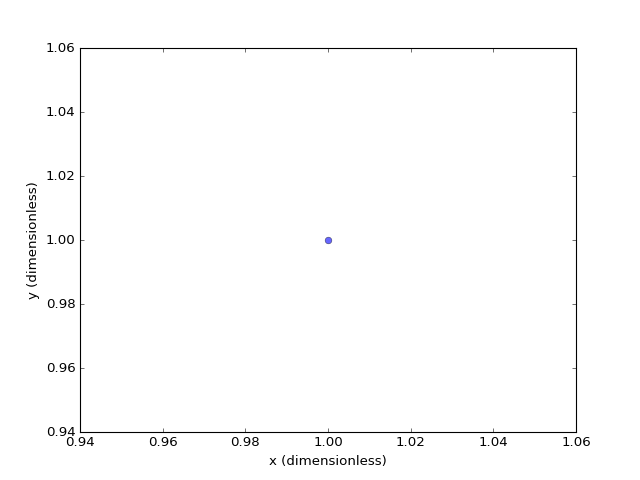

In [42]:
figure2 = newplot()

In [43]:
plot(1, 1)

<IPython.core.display.Javascript object>


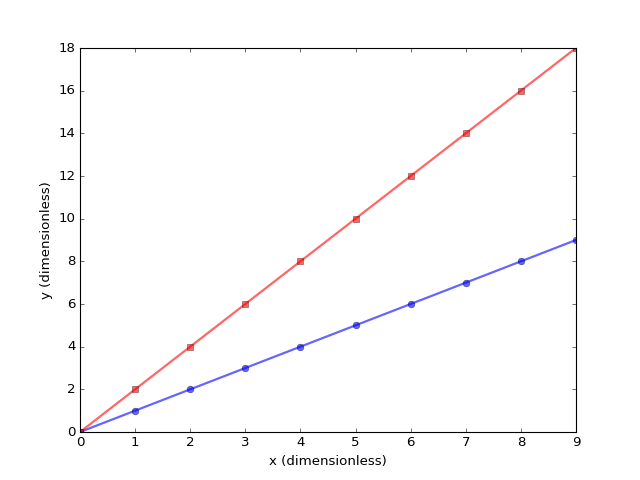

In [44]:
newplot()

for i in range(10):
    plot(i, i, 'bo-')
    plot(i, 2*i, 'rs-')

<IPython.core.display.Javascript object>


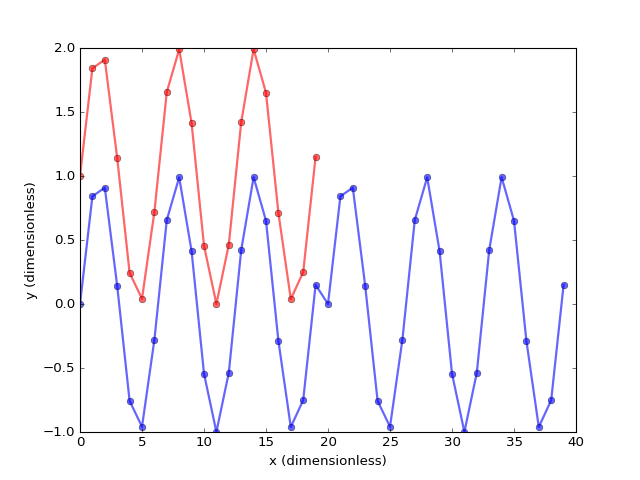

In [45]:
newplot()

In [46]:
xs = np.arange(20)
ys = np.sin(xs)
plot(xs, ys)

In [47]:
plot(xs, ys+1, color='red')

In [48]:
plot(xs+20, ys)

In [49]:
a = 150
b = 150

In [50]:
a_to_b = round(0.05 * a) - round(0.03 * b)

In [51]:
a -= a_to_b
b += a_to_b

In [52]:
a, b

(147.0, 153.0)

<IPython.core.display.Javascript object>


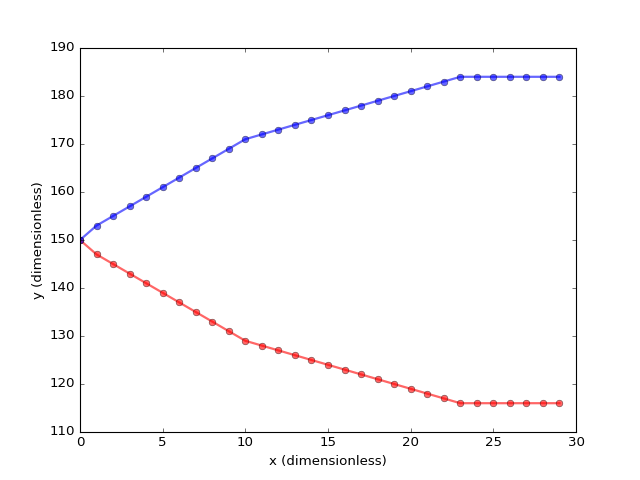

In [53]:
newplot()

a = 150
b = 150

for i in range(30):
    plot(i, a, color='red')
    plot(i, b, color='blue')
    a_to_b = round(0.05 * a) - round(0.03 * b)
    a -= a_to_b
    b += a_to_b

In [54]:
def f(u, t):
    print(u.units)
    return a*u*(1 - u/R)

a = 2
R = 1E+5 * (m)
A = 1 * (m)

import odespy
solver = odespy.RK4(f)
solver.set_initial_condition(A)

T = 10 # end of simulation
N = 30  # no of time steps
time_points = np.linspace(0, T, N+1) * (s)
u, t = solver.solve(time_points)

ImportError: No module named odespy

In [ ]:
value = np.array(f(A, 0), dtype=object)
f(A, 0)
value

In [ ]:
np.asarray(A)

In [ ]:
from scipy.optimize import bisect as root_find

In [ ]:
def f(x):
    print(type(x))
    return x**3 - x**2 - x - 1

In [ ]:
a = 0 * (UNITS.meter)
b = 4 * (UNITS.meter)
res = root_find(f, a, b)

In [ ]:
type(res)

In [ ]:
root_find??

In [88]:
x = 5

def foo():
    print(y)

In [89]:
x

5

In [96]:
def decorate(func):
    x = 7
    y = 3
    def func_wrapper():
        func()
    return func_wrapper

In [97]:
bar = decorate(foo)

In [105]:
bar.func_closure[0].cell_contents.func_name

'foo'

In [93]:
bar()

NameError: global name 'y' is not defined

In [94]:
def foo():
    x = 1
    def bar():
        y = 3
    print(bar.func_closure)

In [95]:
foo()

None
